In [2]:
import os
import stata_setup
import numpy as np
import pandas as pd

## 设置pystata目录
stata_setup.config(os.getenv("STATA_SYSDIR"), 'mp')

In [3]:
from pystata import stata

stata.run('use cfps2010.dta, clear', quietly=True)

In [4]:
stata.run('describe')


Contains data from cfps2010.dta
 Observations:         4,137                  
    Variables:            12                  5 Aug 2022 19:25
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
pid             double  %12.0g     pid        个人id
provcd          double  %24.0g     provcd     省国标码
gender          double  %12.0g     gender     性别
age             float   %9.0g                 年龄
age2            float   %9.0g                 年龄平方
age3            float   %9.0g                 年龄三次方
lninc           float   %9.0g                 收入对数
college         double  %9.0g      yesorno    是否上大学
hukou           double  %12.0g     hukou      3岁时户口性质
sibling         float   %9.0g      yesorno    是否独生子女
race            double  %9.0g      yesorno    是否汉族
fmedu           float   %9.0g  

In [5]:
## 线性回归
%stata reg lninc college, vce(cluster provcd)


Linear regression                               Number of obs     =      4,137
                                                F(1, 24)          =     271.17
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1095
                                                Root MSE          =     1.1498

                                (Std. err. adjusted for 25 clusters in provcd)
------------------------------------------------------------------------------
             |               Robust
       lninc | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     college |    .823612   .0500155    16.47   0.000     .7203851     .926839
       _cons |   9.353189   .1084703    86.23   0.000     9.129317    9.577061
------------------------------------------------------------------------------


In [6]:
## 有放回的1对1匹配
%stata teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu)


Treatment-effects estimation                   Number of obs      =      4,137
Estimator      : propensity-score matching     Matches: requested =          1
Outcome model  : matching                                     min =          1
Treatment model: logit                                        max =         50
------------------------------------------------------------------------------
             |              AI robust
       lninc | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATE          |
     college |
 (是 vs 否)  |   .7867998   .0411656    19.11   0.000     .7061167    .8674829
------------------------------------------------------------------------------


In [7]:
## 带卡尺的有放回的1对1匹配，存在个案无法进行匹配
%stata teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu), caliper(0.02)

Exception in thread Stata:
Traceback (most recent call last):
  File "D:\ProgramData\anaconda3\envs\pystata\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "D:\ProgramData\stata17\utilities\pystata\core\stout.py", line 169, in run
    raise SystemError(output)
SystemError: no propensity-score matches for observation 2607 within caliper 0.02; use
option osample() to identify all observations with deficient matches
r(459);




In [8]:
## 将没有匹配上的个案保存在flag变量中
%stata teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu), caliper(0.02) osample(flag)

Exception in thread Stata:
Traceback (most recent call last):
  File "D:\ProgramData\anaconda3\envs\pystata\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "D:\ProgramData\stata17\utilities\pystata\core\stout.py", line 169, in run
    raise SystemError(output)
SystemError: 1 observation has no propensity-score matches within caliper .02; it is
identified in the osample() variable
r(459);




In [9]:
%stata tab flag


    overlap |
  violation |
  indicator |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      4,136       99.98       99.98
          1 |          1        0.02      100.00
------------+-----------------------------------
      Total |      4,137      100.00


In [10]:
## 排除不符合卡尺要求的个案（只有1个）
%stata teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02)


Treatment-effects estimation                   Number of obs      =      4,136
Estimator      : propensity-score matching     Matches: requested =          1
Outcome model  : matching                                     min =          1
Treatment model: logit                                        max =         50
------------------------------------------------------------------------------
             |              AI robust
       lninc | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATE          |
     college |
 (是 vs 否)  |   .7823973   .0411119    19.03   0.000     .7018194    .8629751
------------------------------------------------------------------------------


In [11]:
## 带卡尺的有放回1对4匹配，此时需要通过设置vce(vcetype)设置正确的标准误
%stata teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02) nneighbor(4) vce(robust, nn(4))


Treatment-effects estimation                   Number of obs      =      4,136
Estimator      : propensity-score matching     Matches: requested =          4
Outcome model  : matching                                     min =          4
Treatment model: logit                                        max =         50
------------------------------------------------------------------------------
             |              AI robust
       lninc | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATE          |
     college |
 (是 vs 否)  |   .7981312   .0398814    20.01   0.000     .7199651    .8762974
------------------------------------------------------------------------------


In [13]:
## 相比于1对1匹配，1对4匹配结果略有上升。哪个结果更可靠呢？此时，需要检验样本的平衡性
## 1对1匹配
stata.run('qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02)')
stata.run('tebalance summarize')
## 1对4匹配
stata.run('qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02) nneighbor(4) vce(robust, nn(4))')
stata.run('tebalance summarize')

(refitting the model using the generate() option)

Covariate balance summary

                         Raw      Matched
-----------------------------------------
Number of obs =        4,136        8,272
Treated obs   =        1,642        4,136
Control obs   =        2,494        4,136
-----------------------------------------

-----------------------------------------------------------------
                |Standardized differences          Variance ratio
                |        Raw     Matched           Raw    Matched
----------------+------------------------------------------------
          hukou |   .2391517   -.0014774      1.082073   .9994289
            age |  -.7809001   -.0058524      .8161995   .9835917
         gender |  -.0813989    .0357897      1.025221   .9881189
           race |  -.0453557   -.0203342      1.199887   1.096473
        sibling |   .3632311    .0106027      2.008184   1.022875
                |
          fmedu |
            是  |   .5411217   -.0152094

In [14]:
stata.run('qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02) nneighbor(4) vce(robust, nn(4))')
stata.run('tebalance summarize')

(refitting the model using the generate() option)

Covariate balance summary

                         Raw      Matched
-----------------------------------------
Number of obs =        4,136        8,272
Treated obs   =        1,642        4,136
Control obs   =        2,494        4,136
-----------------------------------------

-----------------------------------------------------------------
                |Standardized differences          Variance ratio
                |        Raw     Matched           Raw    Matched
----------------+------------------------------------------------
          hukou |   .2391517   -.0031644      1.082073   .9986757
            age |  -.7809001    -.000016      .8161995   .9710056
         gender |  -.0813989    .0745308      1.025221    .971546
           race |  -.0453557    .0349928      1.199887   .8487141
        sibling |   .3632311     .050172      2.008184     1.1103
                |
          fmedu |
            是  |   .5411217   -.0048144


. 
. qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) 
> if flag==0, caliper(0.02)

. tebalance density age
(refitting the model using the generate() option)

. 


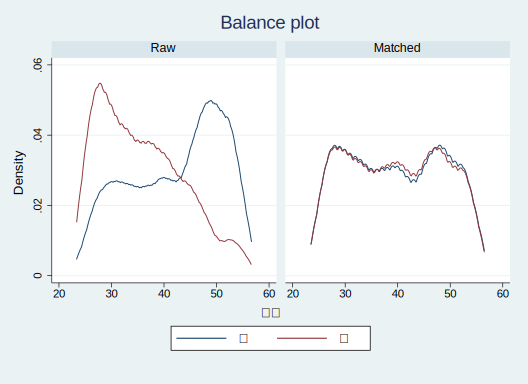

In [17]:
## tebalance density
stata.run('''
qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02)
tebalance density age
''')
## 匹配后概率密度曲线几乎完全重合


. // tebalance box
. qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) 
> if flag==0, caliper(0.02)

. tebalance box age
(refitting the model using the generate() option)

. 


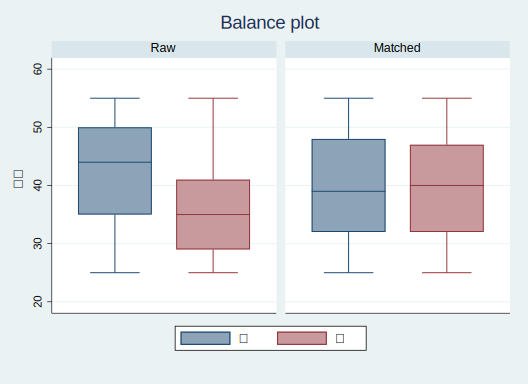

In [19]:
%%stata
// tebalance box
qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02)
tebalance box age


. ## 检查倾向值的共同取值差异
Unknown #command
. qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) 
> if flag==0, caliper(0.02)

. teffects overlap
(refitting the model using the generate() option)

. 


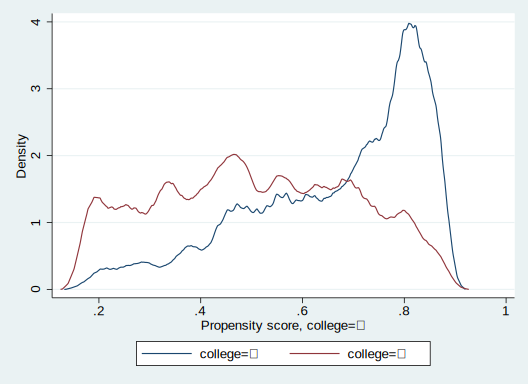

In [20]:
%%stata
## 检查倾向值的共同取值差异
qui teffects psmatch (lninc) (college hukou age gender race sibling i.fmedu) if flag==0, caliper(0.02)
teffects overlap
## 干预组和控制组在倾向值上的重叠范围很大

In [24]:
stata.run('set linesize 200')

In [25]:
## psmatch2命令的使用
## 带卡尺的1对1匹配
%stata psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) caliper(0.02) common ate logit ties odds


Logistic regression                                     Number of obs =  4,136
                                                        LR chi2(7)    = 690.80
                                                        Prob > chi2   = 0.0000
Log likelihood = -2433.071                              Pseudo R2     = 0.1243

------------------------------------------------------------------------------
     college | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       hukou |   .3691967   .0750768     4.92   0.000     .2220487    .5163446
         age |  -.0778884    .004612   -16.89   0.000    -.0869278    -.068849
      gender |  -.0052387   .0707322    -0.07   0.941    -.1438713    .1333939
        race |   -.178265    .155782    -1.14   0.252    -.4835921    .1270622
     sibling |   .1541583   .1050904     1.47   0.142    -.0518152    .3601318
             |
       fmedu |
         是  |   .809

In [26]:
## 带卡尺的1对4匹配
%stata psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) caliper(0.02) neighbor(4) \
common ate logit ties odds quietly

----------------------------------------------------------------------------------------
        Variable     Sample |    Treated     Controls   Difference         S.E.   T-stat
----------------------------+-----------------------------------------------------------
           lninc  Unmatched | 10.1775256   9.35318907   .824336518   .036540222    22.56
                        ATT | 10.1784556   9.47589894   .702556661   .050086699    14.03
                        ATU | 9.35371331   10.2115772   .857863905            .        .
                        ATE |                           .796305761            .        .
----------------------------+-----------------------------------------------------------
Note: S.E. does not take into account that the propensity score is estimated.

 psmatch2: |   psmatch2: Common
 Treatment |        support
assignment | Off suppo  On suppor |     Total
-----------+----------------------+----------
 Untreated |         4      2,490 |     2,494 
   Treated

In [27]:
## 半径匹配
%stata psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) caliper(0.02) radius common ate logit quietly

----------------------------------------------------------------------------------------
        Variable     Sample |    Treated     Controls   Difference         S.E.   T-stat
----------------------------+-----------------------------------------------------------
           lninc  Unmatched | 10.1775256   9.35318907   .824336518   .036540222    22.56
                        ATT | 10.1778062   9.48062537   .697180782   .042803897    16.29
                        ATU | 9.35318907   10.2249628     .8717737            .        .
                        ATE |                            .80256189            .        .
----------------------------+-----------------------------------------------------------
Note: S.E. does not take into account that the propensity score is estimated.

 psmatch2: |   psmatch2: Common
 Treatment |        support
assignment | Off suppo  On suppor |     Total
-----------+----------------------+----------
 Untreated |         0      2,494 |     2,494 
   Treated

In [28]:
## 核匹配
%stata psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) kernel common ate logit quietly

----------------------------------------------------------------------------------------
        Variable     Sample |    Treated     Controls   Difference         S.E.   T-stat
----------------------------+-----------------------------------------------------------
           lninc  Unmatched | 10.1775256   9.35318907   .824336518   .036540222    22.56
                        ATT | 10.1778062   9.47873591   .699070244   .042010122    16.64
                        ATU | 9.35318907   10.2248952   .871706092            .        .
                        ATE |                             .8032701            .        .
----------------------------+-----------------------------------------------------------
Note: S.E. does not take into account that the propensity score is estimated.

 psmatch2: |   psmatch2: Common
 Treatment |        support
assignment | Off suppo  On suppor |     Total
-----------+----------------------+----------
 Untreated |         0      2,494 |     2,494 
   Treated


. 
. qui psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) kernel common ate logit quietly

. pstest, both graph

----------------------------------------------------------------------------------------
                Unmatched |       Mean               %reduct |     t-test    |  V(T)/
Variable          Matched | Treated Control    %bias  |bias| |    t    p>|t| |  V(C)
--------------------------+----------------------------------+---------------+----------
hukou                  U  | .47808   .36087     23.9         |   7.56  0.000 |     .
                       M  |  .4768   .45253      5.0    79.3 |   1.39  0.164 |     .
                          |                                  |               |
age                    U  | 35.745   42.282    -78.1         | -24.32  0.000 |  0.82*
                       M  | 35.769    35.67      1.2    98.5 |   0.35  0.725 |  0.94
                          |                                  |               |
gende

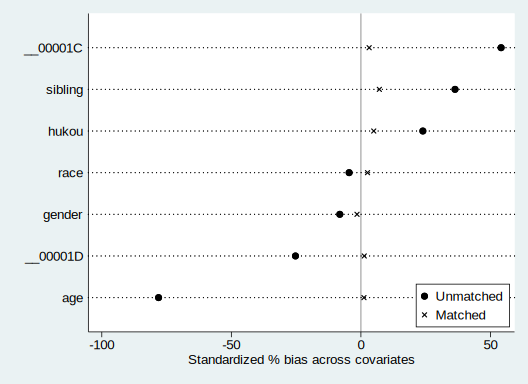

In [30]:
## 对psmatch2的结果进行平衡性检验
stata.run('''
qui psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) kernel common ate logit quietly
pstest, both graph
''')


. 
. qui psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) kernel common ate logit quietly

. psgraph, bin(10)

. 


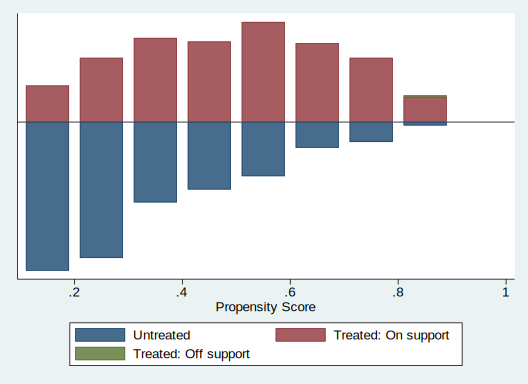

In [32]:
## 检查共同取值范围
stata.run('''
qui psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) kernel common ate logit quietly
psgraph, bin(10)
'''
)

In [33]:
##  敏感性分析（psmatch2 只针对带卡尺的1对1匹配）
%stata psmatch2 college hukou age gender race sibling i.fmedu if flag==0, outcome(lninc) caliper(0.02) common logit ties odds quietly

----------------------------------------------------------------------------------------
        Variable     Sample |    Treated     Controls   Difference         S.E.   T-stat
----------------------------+-----------------------------------------------------------
           lninc  Unmatched | 10.1775256   9.35318907   .824336518   .036540222    22.56
                        ATT | 10.1784556   9.47407844   .704377162   .054015335    13.04
----------------------------+-----------------------------------------------------------
Note: S.E. does not take into account that the propensity score is estimated.

 psmatch2: |   psmatch2: Common
 Treatment |        support
assignment | Off suppo  On suppor |     Total
-----------+----------------------+----------
 Untreated |         0      2,494 |     2,494 
   Treated |         7      1,635 |     1,642 
-----------+----------------------+----------
     Total |         7      4,129 |     4,136 


$\Gamma$ > 2 表示通过敏感性分析

In [39]:
%%stata
## 该命令只能对1对1匹配下的ATTT进行敏感性分析
gen diff=lninc-_lninc if _treated==1 & _support==1 & flag==0
rbounds diff, gamma(1 (1) 5)


. ## 该命令只能对1对1匹配下的ATTT进行敏感性分析
Unknown #command
. gen diff=lninc-_lninc if _treated==1 & _support==1 & flag==0
(2,502 missing values generated)

. rbounds diff, gamma(1 (1) 5)

Rosenbaum bounds for diff (N = 1635 matched pairs)

Gamma           sig+      sig-    t-hat+    t-hat-       CI+       CI-
----------------------------------------------------------------------
    1              0         0   .679028   .679028   .630224   .728463  
    2              0         0   .380941   .985865   .329637    1.0398  
    3        8.1e-12         0   .210826   1.16725     .1551   1.22661  
    4        .001779         0     .0917   1.29513   .031636   1.35918  
    5        .501555         0  -3.4e-07   1.39373  -.065069    1.4644  

* gamma  - log odds of differential assignment due to unobserved factors
  sig+   - upper bound significance level
  sig-   - lower bound significance level
  t-hat+ - upper bound Hodges-Lehmann point estimate
  t-hat- - lower bound Hodges-Lehmann point estimate


In [40]:
%stata rbounds diff, gamma(4 (0.1) 5)


Rosenbaum bounds for diff (N = 1635 matched pairs)

Gamma           sig+      sig-    t-hat+    t-hat-       CI+       CI-
----------------------------------------------------------------------
    1              0         0   .679028   .679028   .630224   .728463  
    4        .001779         0     .0917   1.29513   .031636   1.35918  
  4.1        .004789         0   .081498   1.30569   .020604   1.37133  
  4.2        .011459         0   .071757   1.31663   .010318   1.38245  
  4.3        .024612         0   .061753   1.32688   3.4e-07   1.39327  
  4.4        .047872         0    .05268   1.33685  -.009798   1.40459  
  4.5        .085031         0    .04293   1.34712  -.019613    1.4148  
  4.6        .139007         0   .033641   1.35616  -.029213   1.42535  
  4.7        .210731         0   .025061   1.36639  -.038481   1.43508  
  4.8        .298408         0   .016951   1.37553  -.047947   1.44519  
  4.9        .397505         0   .008004   1.38522  -.056148   1.45504  
  